# gender-disparities-in-stem

The underrepresentation of women in STEM fields is a global concern that has sparked debate regarding the need for encouragement versus inherent interest. This project seeks to investigate this issue by analyzing data collected from prominent social media platforms, Reddit.

In [1]:
## Libraries
import re
import unidecode
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from sentence_transformers import SentenceTransformer, util
import torch
from sklearn.cluster import OPTICS
import seaborn as sns
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import asyncpraw
import nest_asyncio
import csv
import asyncio
from datetime import datetime
import openai
import signal
from contextlib import contextmanager
from tqdm import tqdm
import pandas as pd
from time import sleep
import scipy.stats as stats
from scipy.stats import boxcox
import os


openai.api_key = os.environ.get('OPENAI_API_KEY')


nest_asyncio.apply()
%matplotlib inline

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/veronicamataramirez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/veronicamataramirez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/veronicamataramirez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Reddit API credentials
client_id = os.environ['client_id']
client_secret = os.environ['client_secret']
user_agent = os.environ['user_agent']


### Collecting data

In [2]:
# Expanded list of specific word pairs for titles
word_pairs = [

    ["woman", "STEM"], ["woman", "math"], ["woman", "science"], ["woman", "engineering"], ["woman", "technology"],
    ["female", "engineer"], ["girl", "programming"], ["lady", "biotech"], ["woman", "astronomy"], ["female", "physics"],
    ["woman", "data science"], ["female", "robotics"], ["woman", "cybersecurity"], ["woman", "AI"], ["woman", "algorithms"],
    ["female", "software"], ["woman", "computing"], ["woman", "bioinformatics"], ["woman", "neuroscience"], ["woman", "engineer"],
    ["woman", "quota"], ["female", "discrimination"], ["woman", "gender bias"], ["female", "underrepresentation"],
    ["woman", "leadership"], ["female", "mentorship"], ["woman", "glass ceiling"], ["woman", "work-life balance"],
    ["woman", "gender pay gap"], ["female", "career advancement"], ["woman", "workplace harassment"],
    ["female", "professional development"], ["woman", "industry bias"], ["woman", "education gap"], ["woman", "role model"],
    ["female", "empowerment"], ["woman", "gender stereotype"], ["female", "workplace equality"], ["woman", "skill gap"],
    ["woman", "managerial roles"], ["female", "entrepreneurship"], ["woman", "innovation"], ["female", "research contribution"],
    ["woman", "scholarship"], ["female", "academic publication"], ["woman", "scientific breakthrough"], ["woman", "patent"],
    ["female", "technical expertise"], ["woman", "conference speaker"], ["woman", "panel discussion"], ["female", "mentor"],
    ["woman", "advocacy"], ["female", "community support"], ["woman", "networking"], ["woman", "policy influence"],
    ["female", "legislation"], ["woman", "STEM education"], ["woman", "coding workshop"], ["female", "startup founder"],
    ["woman", "tech industry"], ["female", "engineering challenge"], ["woman", "mathematical theory"], ["woman", "software development"],
    ["female", "lab research"], ["woman", "fieldwork"], ["woman", "academic tenure"], ["female", "science communication"],
    ["woman", "public speaking"], ["female", "STEM advocacy"], ["woman", "outreach program"], ["woman", "grant funding"],  ["woman", "stem", 'mother'], ["woman", "stem", 'baby']
]



def title_contains_words(title, word_pair):
  """Check if title contains all words in the word pair."""
  return all(word.lower() in title.lower() for word in word_pair)

async def fetch_comments(submission, retry_count=0, max_comments=500):
    try:
        await submission.comments.replace_more(limit=500)
        comments_data = []
        for comment in submission.comments.list()[:max_comments]:  # Limiting to the first 300 comments
            author_name = comment.author.name if comment.author else "Deleted User"
            comment_date = datetime.fromtimestamp(comment.created_utc).strftime('%Y-%m-%d %H:%M:%S')
            comments_data.append((comment.body, comment.score, author_name, comment_date))
        return comments_data
    except asyncpraw.exceptions.RedditAPIException as e:
        print(f"Reddit API exception: {e}")
        return []

async def append_to_csv(entry, filename):
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        title = entry['title']
        url = entry['url']
        content = entry['content']
        print("Total number of comments (limited to first 300):", len(entry['comments']))
        for comment, score, author, date in entry['comments']:
            writer.writerow([title, url, content, comment, score, author, date])


async def search_reddit_and_get_comments(word_pairs, filename, limit=1000):
    async with asyncpraw.Reddit(client_id=client_id,
                                client_secret=client_secret,
                                user_agent=user_agent) as reddit:
        with open(filename, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow(['Title', 'URL', 'Content', 'Comment', 'Comment Score', 'Author', 'Date'])

        for word_pair in word_pairs:
            search_query = f'{" ".join(word_pair)}'
            all_posts = await reddit.subreddit('all')
            top_posts = all_posts.search(search_query, limit=limit)

            async for post in top_posts:
                if title_contains_words(post.title, word_pair) and not(title_contains_words(post.title, ['stem','cells'])) and not(title_contains_words(post.title, ['stem','cell'])) :
                    print(post.title)
                    try:
                        submission = await reddit.submission(id=post.id)
                        # Load the subreddit details with a timeout
                        try:
                            await asyncio.wait_for(submission.subreddit.load(), 20)
                        except asyncio.TimeoutError:
                            print(f"Timeout occurred for subreddit: {post.subreddit.display_name}. Skipping to next post.")
                            continue

                        # Check if subreddit is private
                        if submission.subreddit.subreddit_type == 'private':
                            print(f"Skipping private subreddit: {submission.subreddit.display_name}")
                            continue

                        # Fetch comments with a timeout
                        try:
                            comments = await asyncio.wait_for(fetch_comments(submission, max_comments=500), 5)
                        except asyncio.TimeoutError:
                            print(f"Timeout occurred for comments in post: {submission.title}. Skipping to next post.")
                            continue

                        entry = {
                            "title": submission.title,
                            "url": submission.url,
                            "content": submission.selftext,
                            "comments": comments
                        }
                        await append_to_csv(entry, filename)
                    except asyncpraw.exceptions.RedditAPIException:
                        await asyncio.sleep(10)
                        continue
                    except Exception as e:
                        print(f"An error occurred: {e}")
                        await asyncio.sleep(10)
                        continue

# Rest of the script remains unchanged


# Set the filename
filename = '/data/reddit_data_4.csv'

# Run the script and save the data for each word pair
await search_reddit_and_get_comments(word_pairs, filename, limit=1000)

print("Data saved to 'reddit_data.csv'")


### Cleaning text data

In [3]:
def lower_casing_text(text):
    # Convert text to lowercase
    text = text.lower()
    text = re.sub(r"[-()\"#/@;:<>{}=~|.?,*]", "", text)
    return text

def contains_undesired_words(text):
    # List of undesired words
    undesired_words = ['bot', 'deleted', 'removed', 'nan', 'comment remove']
    # Check if any of the undesired words is in the text
    return any(word in text.lower() for word in undesired_words)

# Remove newlines and tabs
def remove_newlines_tabs(text):
    return text.replace('\\n', ' ').replace('\n', ' ').replace('\t', ' ').replace('\\', ' ').replace('.com', '.com')

# Strip HTML tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text(separator=" ")

# Remove anything that starts with http or www
def remove_links(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    return text

# Remove whitespaces
def remove_whitespace(text):
    text = re.sub(r'\s+', ' ', text)
    return text.replace('?', ' ? ').replace(')', ') ')

# Remove accented characters
def accented_characters_removal(text):
    return unidecode.unidecode(text)


# Reduce incorrect character repetition
def reducing_incorrect_character_repeatation(text):
    text = re.compile(r'([A-Za-z])\1{1,}', re.DOTALL).sub(r'\1\1', text)
    text = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}').sub(r'\1', text)
    return re.sub(' {2,}', ' ', text)

# Expand contractions
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
}

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
    expanded_text = contractions_pattern.sub(expand_match, text)
    return expanded_text

# Remove special characters
def removing_special_characters(text):
    return re.sub(r"[^a-zA-Z0-9]", ' ', text)


# Correct mis-spelled words
def spelling_correction(text):
    spell = Speller(lang='en')
    return spell(text)

# Remove stopwords
def stopword_removal(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

# Lemmatization
def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_text = [lemmatizer.lemmatize(word, 'v') for word in tokens]
    return ' '.join(lemmatized_text)

# Function to apply all the preprocessing steps
def preprocess_text(text):
    text = lower_casing_text(text)
    text = remove_newlines_tabs(text)
    text = strip_html_tags(text)
    text = remove_links(text)
    text = remove_whitespace(text)
    text = accented_characters_removal(text)
    text = reducing_incorrect_character_repeatation(text)
    text = expand_contractions(text)
    text = removing_special_characters(text)
    #text = spelling_correction(text)
    text = stopword_removal(text)
    text = lemmatization(text)
    
    return text


# Read the dataset
data = pd.read_csv('../data/reddit_data_4.csv')
# Remove the DUPLICATE rows
data = data.drop_duplicates(keep='first')


In [93]:
data.shape

(22076, 8)

In [88]:
data.Author.count()

11560

In [4]:
data['content_clean'] = data['Content'].astype(str).apply(preprocess_text)

In [5]:
data['comment_clean'] = data['Comment'].astype(str).apply(preprocess_text)

In [6]:
data = data[(data['comment_clean'].str.len() > 20)]

In [7]:
df_cleaned = data[~data['content_clean'].astype(str).apply(contains_undesired_words) &
                 ~data['comment_clean'].astype(str).apply(contains_undesired_words)]

In [91]:
df_cleaned.shape

(14268, 8)

In [92]:
df_cleaned.Author.count()

6538

In [9]:
# get the max and min date of the dataset
print(df_cleaned['Date'].min(), df_cleaned['Date'].max())

## Descriptive Analisis

In [15]:
from collections import Counter

def get_word_frequency(text_series):

    text_series = text_series.astype(str)
    word_list = ' '.join(text_series).split()
    word_freq = Counter(word_list)
    return pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

word_freq_df = get_word_frequency(df_cleaned['comment_clean'])
print(word_freq_df.head(100))  # Display top 10 frequent words


        Word  Frequency
33     women      13710
120      get      13566
71      like      13384
170    would      12899
136   people      12532
..       ...        ...
276  comment       1974
399      bad       1962
523   though       1953
210  problem       1941
82     leave       1928

[100 rows x 2 columns]


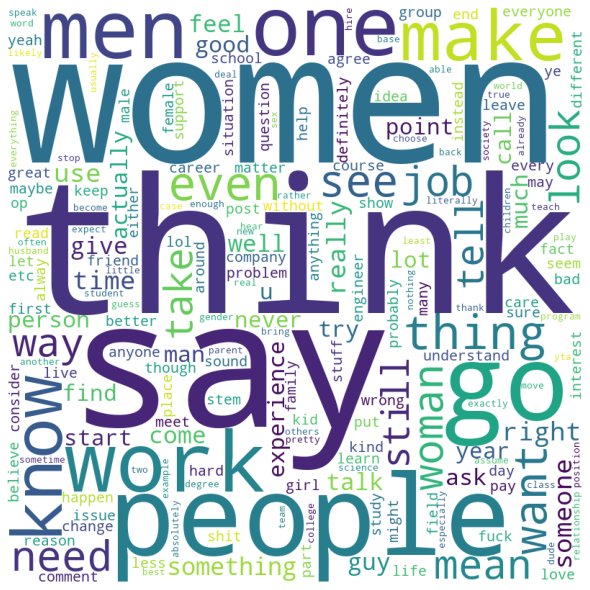

In [16]:
# WordCloud graph
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(STOPWORDS), 
                min_font_size = 10).generate(' '.join(df_cleaned['comment_clean'].astype(str)))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()


## Prescriptive analysis

In [19]:
#Frequent patterns LDA
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim import corpora
import string

nltk.download('stopwords')
nltk.download('wordnet')

# Sample data: replace this with your Reddit comments
documents = df_cleaned['comment_clean'].tolist()
# Preprocess data
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in documents] 
# Creating the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using the dictionary
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# Create an LDA model
lda_model = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=5, id2word = dictionary, passes=15)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/veronicamataramirez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/veronicamataramirez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Topic: 0 
Words: 0.019*"work" + 0.016*"get" + 0.012*"job" + 0.011*"year" + 0.009*"go" + 0.008*"engineer" + 0.007*"would" + 0.007*"time" + 0.007*"make" + 0.007*"one"
Topic: 1 
Words: 0.021*"asian" + 0.015*"conservative" + 0.012*"vote" + 0.011*"racist" + 0.011*"de" + 0.010*"nazi" + 0.008*"party" + 0.007*"si" + 0.007*"mormon" + 0.007*"white"
Topic: 2 
Words: 0.021*"like" + 0.018*"say" + 0.017*"would" + 0.015*"think" + 0.014*"know" + 0.013*"make" + 0.013*"people" + 0.012*"get" + 0.011*"thing" + 0.009*"want"
Topic: 3 
Words: 0.052*"woman" + 0.026*"men" + 0.014*"people" + 0.010*"gender" + 0.009*"think" + 0.008*"male" + 0.008*"female" + 0.007*"say" + 0.006*"would" + 0.006*"field"
Topic: 4 
Words: 0.022*"fuck" + 0.010*"game" + 0.010*"te" + 0.010*"story" + 0.010*"girlfriend" + 0.009*"get" + 0.009*"guy" + 0.008*"shit" + 0.008*"manti" + 0.007*"watch"


In [20]:
df = df_cleaned.copy()

### Embeddings

In [23]:
# Load a pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Convert comments to embeddings and then to PyTorch tensors
embeddings = model.encode(df['comment_clean'].tolist(), show_progress_bar=True)
embeddings = torch.tensor(embeddings)

Batches:   0%|          | 0/1483 [00:00<?, ?it/s]

In [24]:
# Dimensionality Reduction with UMAP
umap_model = umap.UMAP(n_neighbors=20, min_dist=0.05, n_components=2, random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)
reduced_embeddings = torch.tensor(reduced_embeddings)

/Users/veronicamataramirez/miniforge3/envs/hbw/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Clustering

In [25]:
# Clustering
clustering_model = OPTICS(min_samples=3, xi=0.005, min_cluster_size=0.05)

In [26]:
clustering_model.fit(reduced_embeddings)

OPTICS(min_cluster_size=0.05, min_samples=3, xi=0.005)

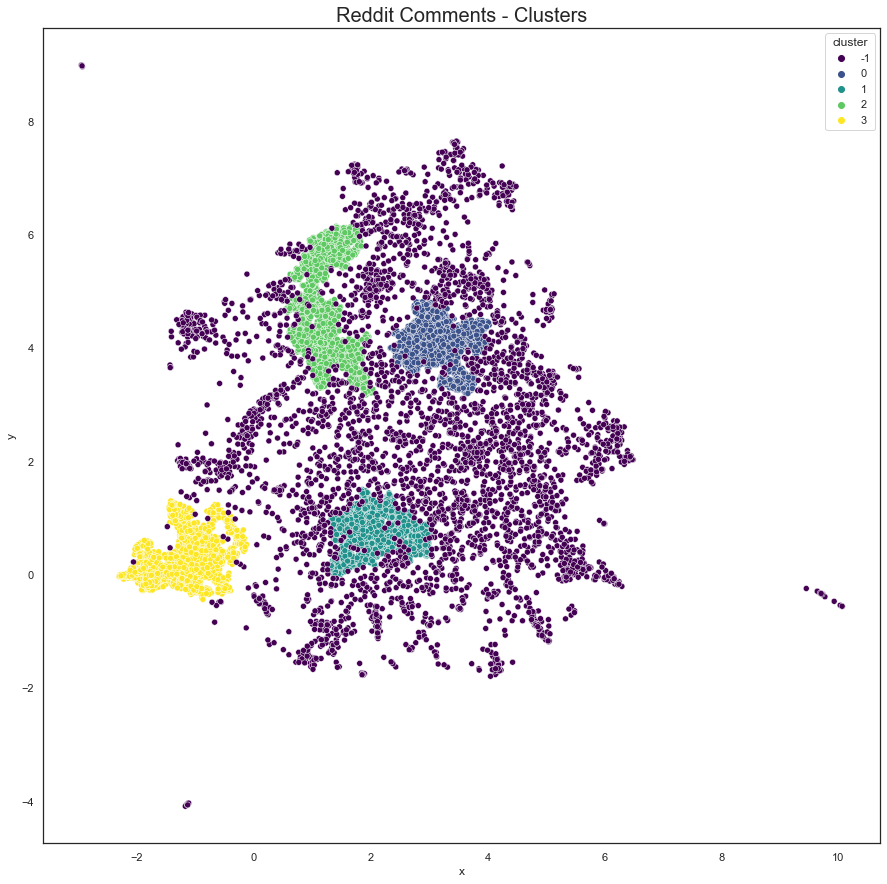

In [27]:
# Create a dataframe with the reduced embeddings
df_embeddings = pd.DataFrame(reduced_embeddings.numpy(), columns=['x', 'y'])
# Add the cluster labels
df_embeddings['cluster'] = clustering_model.labels_
# Plot the clusters
sns.set(style='white', rc={'figure.figsize':(15,15)})
sns.scatterplot(data=df_embeddings, x='x', y='y', hue='cluster', palette='viridis', alpha=1)
plt.title('Reddit Comments - Clusters', fontsize=20)
plt.show()


In [28]:
df_embeddings.head(2)

,x,y,cluster
0,3.317650,3.447819,0
3,2.627817,4.040644,0


In [29]:
# merge the embeddings with the original dataframe
df_clustered = pd.merge(df, df_embeddings, left_index=True, right_index=True)

In [32]:
df_clustered.shape

(13682, 11)

In [75]:
df_clustered

,Unnamed: 0,title,url,content,comment,comment Score,content_clean,comment_clean,x,y,cluster
0,285.0,I'm sick of being a woman in STEM.,https://www.reddit.com/r/TwoXChromosomes/comme...,Despite being more technically competent than ...,I feel this. I'm the only woman on my team at ...,362.0,despite technically competent many male counte...,feel woman team work definitely give respect m...,3.317650,3.447819,0
5,290.0,I'm sick of being a woman in STEM.,https://www.reddit.com/r/TwoXChromosomes/comme...,Despite being more technically competent than ...,I could have absolutely written this post. I s...,31.0,despite technically competent many male counte...,could absolutely write post share sentiment so...,2.673621,3.961848,0


In [33]:
## get the nan values in the comment_clean
df_nan = df_clustered[df_clustered['comment_clean'].isna()]
df_nan

,Unnamed: 0,title,url,content,comment,comment Score,content_clean,comment_clean,x,y,cluster


In [34]:
# print the top 10 comments in each cluster and the number of comments in each cluster
for cluster in df_embeddings['cluster'].unique():
    print(f'Cluster {cluster}:')
    print(f'Number of comments: {len(df_embeddings[df_embeddings["cluster"] == cluster])}')

Cluster 0:
Number of comments: 2372
Cluster 2:
Number of comments: 2990
Cluster 1:
Number of comments: 2532
Cluster 3:
Number of comments: 2374
Cluster -1:
Number of comments: 4000


In [35]:
df_clustered.cluster.value_counts()

-1    3837
 2    2859
 1    2425
 3    2288
 0    2273
Name: cluster, dtype: int64

In [36]:
filtered_df = df_clustered[df_clustered['cluster'] != -1]

In [37]:
filtered_df.head(2)

,Unnamed: 0,title,url,content,comment,comment Score,content_clean,comment_clean,x,y,cluster
0,285.0,I'm sick of being a woman in STEM.,https://www.reddit.com/r/TwoXChromosomes/comme...,Despite being more technically competent than ...,I feel this. I'm the only woman on my team at ...,362.0,despite technically competent many male counte...,feel woman team work definitely give respect m...,3.317650,3.447819,0
5,290.0,I'm sick of being a woman in STEM.,https://www.reddit.com/r/TwoXChromosomes/comme...,Despite being more technically competent than ...,I could have absolutely written this post. I s...,31.0,despite technically competent many male counte...,could absolutely write post share sentiment so...,2.673621,3.961848,0


In [59]:
# print the top 10 comments in each cluster and the number of comments
for cluster in filtered_df['cluster'].unique():
    print(f'Cluster {cluster}:')
    for comment in filtered_df[filtered_df['cluster'] == cluster]['comment'].head(10):
        print(comment)


Cluster 0:
I feel this. I'm the only woman on my team at work and I'm definitely not given the same respect as all the men show to one another.
I could have absolutely written this post. I share the same sentiment here. Sometimes I wonder why I chose to work in such a field. Every day feels like a battle. And to make matters worse, being Canadian, it's not even worth the money (we make half as much as Americans in STEM fields). Sometimes I wonder if there's something I could work as in STEM that could make use of my ability all the while not draining what is left of my sanity... In any case, I am so, so sorry you have to endure that. But you're not alone. I'm here. We're here!
I know a couple of women who are very big in tech and they get talked down to often. One woman had some men at an event start up, she’s in a wheelchair so she just turned and rolled away. She and her ex husband started KX Systems. The other woman is… fucking Judy Estrin. When people ask Judy what she does she ref

### Chatgpt 3.5 turbo -  classifier

In [40]:
# Timeout decorator
class TimeoutException(Exception):
    pass

@contextmanager
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

def classify_comment(comment):
    try:
        with time_limit(15):  # Timeout for each request
            response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": "You are a classifier that categorizes comments into 'discouraging_women', 'women_lack_interest', 'encouraging_women', or 'women_interest_in_stem'."},
                    {"role": "user", "content": comment}
                ]
            )
            
            category = response['choices'][0]['message']['content'].strip()
            if category.startswith("Category: "):
                category = re.sub(r"^Category: ", "", category)
            if category not in ['discouraging_women', 'women_lack_interest', 'encouraging_women', 'women_interest_in_stem']:
                category = 'Unclassified'
            return category
    except TimeoutException:
        sleep(10)
        print("Request timed out.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


# Reset the index
df = df.reset_index(drop=True)

# Classify each comment
classified_data = []

for idx, row in tqdm(filtered_df.iterrows(), total=filtered_df.shape[0], desc="Classifying comments"):
    category = classify_comment(row['comment'])
    classified_data.append((idx, row['comment'], category))


# Convert classified data to DataFrame
classified_df = pd.DataFrame(classified_data, columns=['Index', 'comment', 'Category'])
print(classified_df)



In [41]:
#Create a new DataFrame from the classified comments
classified_df = pd.DataFrame(classified_data, columns=['index', 'Comment', 'category'])
classified_df

In [65]:
classified_df.head(2)

,index,Comment,category
0,0,I feel this. I'm the only woman on my team at ...,discouraging_women
1,5,I could have absolutely written this post. I s...,encouraging_women


In [66]:
classified_df.rename(columns={'Comment': 'comment'}, inplace=True)

In [67]:
# merge the classified dataframe with the original dataframe
df_classified_clustered = pd.merge(df_cleaned, classified_df, on='comment')

In [68]:
df_classified_clustered.head(2)

,Unnamed: 0,title,url,content,comment,comment Score,content_clean,comment_clean,index,category
0,285.0,I'm sick of being a woman in STEM.,https://www.reddit.com/r/TwoXChromosomes/comme...,Despite being more technically competent than ...,I feel this. I'm the only woman on my team at ...,362.0,despite technically competent many male counte...,feel woman team work definitely give respect m...,0,discouraging_women
1,290.0,I'm sick of being a woman in STEM.,https://www.reddit.com/r/TwoXChromosomes/comme...,Despite being more technically competent than ...,I could have absolutely written this post. I s...,31.0,despite technically competent many male counte...,could absolutely write post share sentiment so...,5,encouraging_women


### Word Cloud

discouraging_women


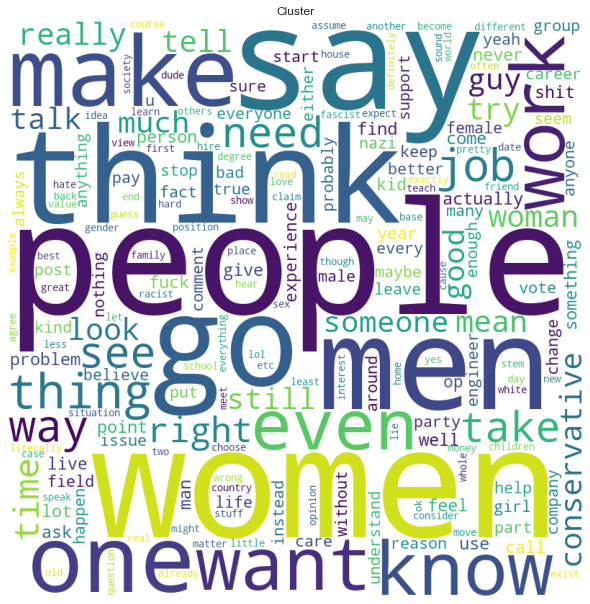

encouraging_women


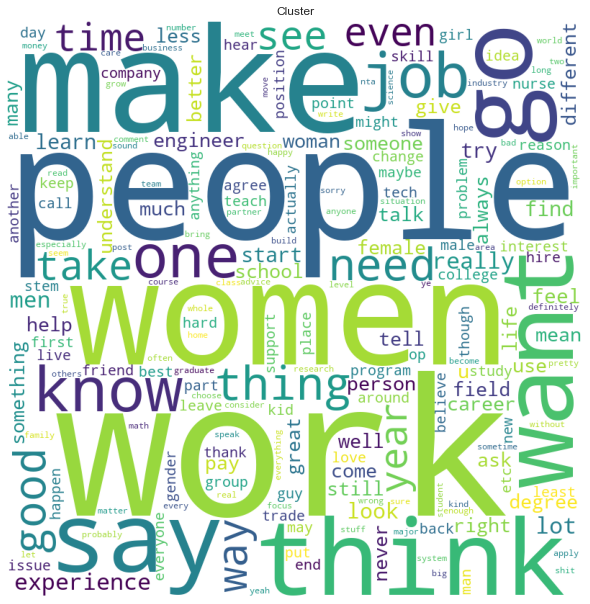

women_lack_interest


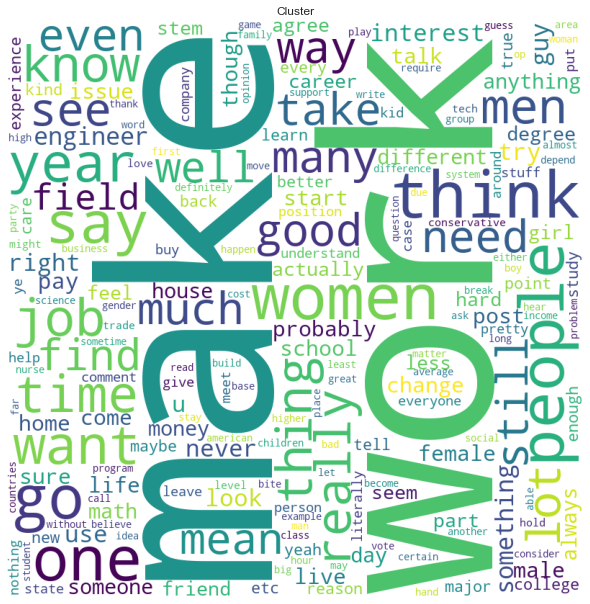

Unclassified


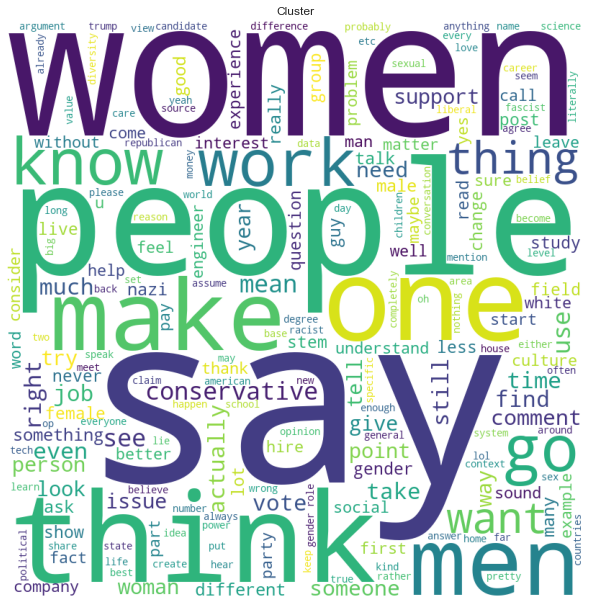

women_interest_in_stem


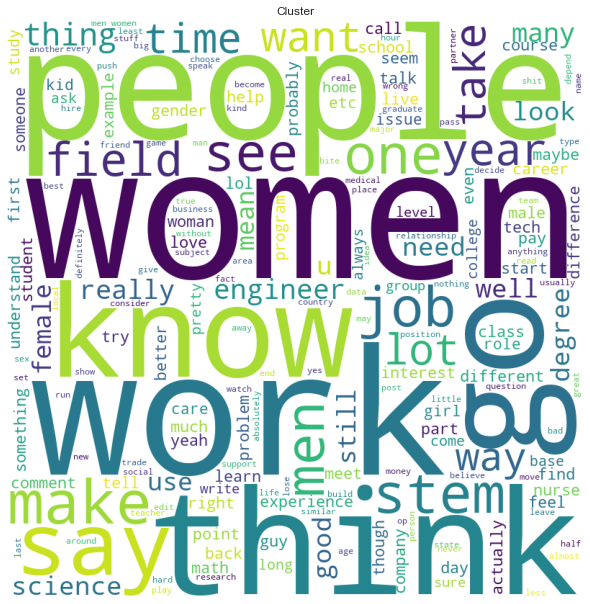

nan


In [69]:
# Create a word cloud for each cluster
for cluster in df_classified_clustered['category'].unique():
    # Get all comments for the current cluster
    print(cluster)
   # filter the classified_df by the cluster
    comments = df_classified_clustered[df_classified_clustered['category'] == cluster]['comment_clean']
    if len(comments)  > 1:
        # Generate a word cloud
        wordcloud = WordCloud(width = 800, height = 800, 
                        background_color ='white', 
                        stopwords = set(STOPWORDS), 
                        min_font_size = 10).generate(' '.join(comments))
        
        # Plot the word cloud
        plt.figure(figsize = (8, 8), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.title(f'Cluster')
        plt.show()

### Conclutions

##### Checking for significant statistical difference between means

In [70]:
df_clustered['cluster'].value_counts()

-1    3837
 2    2859
 1    2425
 3    2288
 0    2273
Name: cluster, dtype: int64

In [ ]:
df_clustered['cluster']

In [71]:
df_classified_clustered = pd.merge(classified_df, filtered_df, on='comment')

In [72]:
df_classified_clustered

,index,comment,category,Unnamed: 0,title,url,content,comment Score,content_clean,comment_clean,x,y,cluster
0,0,I feel this. I'm the only woman on my team at ...,discouraging_women,285.0,I'm sick of being a woman in STEM.,https://www.reddit.com/r/TwoXChromosomes/comme...,Despite being more technically competent than ...,362.0,despite technically competent many male counte...,feel woman team work definitely give respect m...,3.317650,3.447819,0
1,5,I could have absolutely written this post. I s...,encouraging_women,290.0,I'm sick of being a woman in STEM.,https://www.reddit.com/r/TwoXChromosomes/comme...,Despite being more technically competent than ...,31.0,despite technically competent many male counte...,could absolutely write post share sentiment so...,2.673621,3.961848,0


In [73]:
# Find the mean score for each category
df_classified_clustered.groupby('category')['comment Score'].mean()

category
Unclassified               7.650899
discouraging_women        16.051175
encouraging_women         19.794610
women_interest_in_stem     4.998201
women_lack_interest       13.663498
Name: comment Score, dtype: float64

In [77]:
cluster1_scores =df_classified_clustered[df_classified_clustered['category'] == 'discouraging_women']['comment Score']
cluster2_scores = df_classified_clustered[df_classified_clustered['category'] == 'encouraging_women']['comment Score']


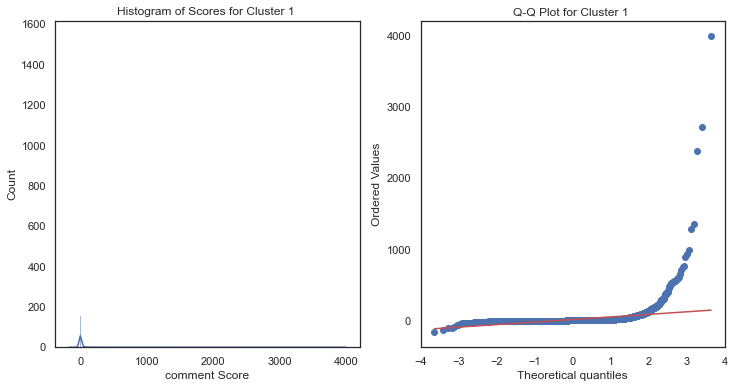

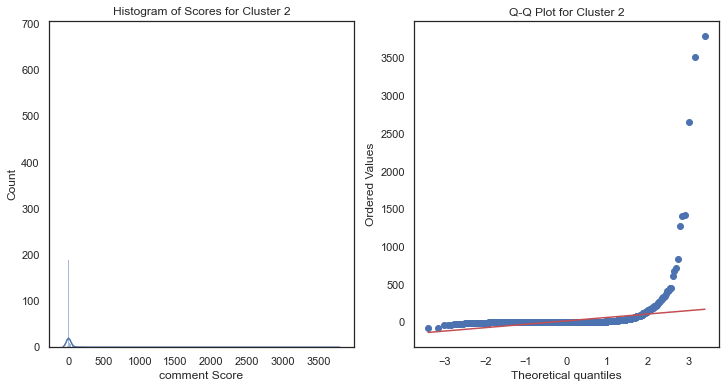

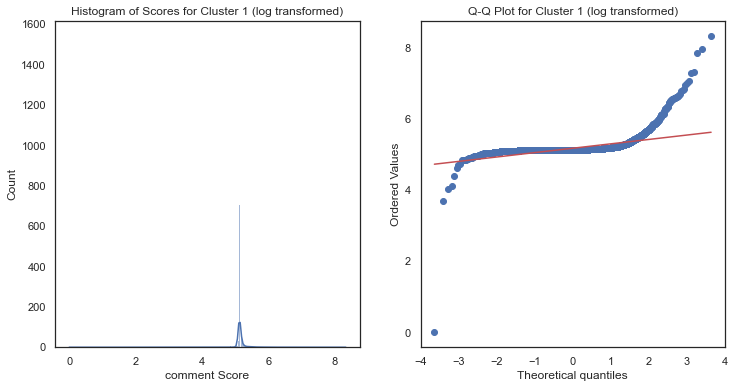

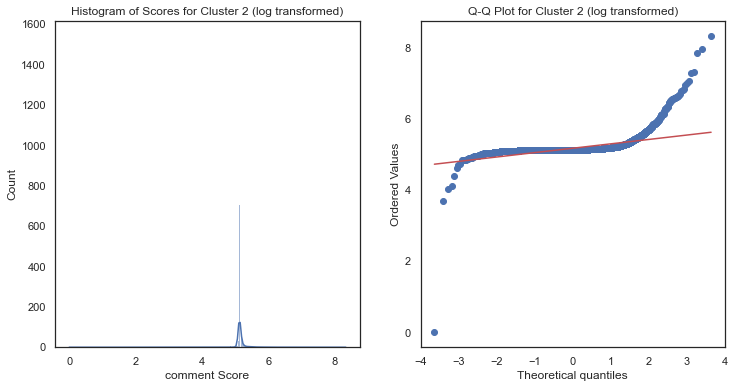

In [78]:
# Visual check with histograms and Q-Q plots
def plot_distribution(cluster_scores, cluster_name):
    # Histogram
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(cluster_scores, kde=True)
    plt.title(f'Histogram of Scores for {cluster_name}')

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(cluster_scores, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {cluster_name}')

    plt.show()

# Shift data to make all values positive
shifted_data = cluster1_scores - cluster1_scores.min() + 1
log_transformed = np.log(shifted_data)

plot_distribution(cluster1_scores, 'Cluster 1 ')
plot_distribution(cluster2_scores, 'Cluster 2')

plot_distribution(log_transformed, 'Cluster 1 (log transformed)')

shifted_data = cluster2_scores - cluster2_scores.min() + 1
log_transformed2 = np.log(shifted_data)
plot_distribution(log_transformed, 'Cluster 2 (log transformed)')

HO: There is no significant difference between the mean scores of the two groups: 'discouraging_women' and 'women_lack_interest'.

H1:  There is a significant difference between the mean scores of the two groups: 'discouraging_women' and 'women_lack_interest'.

alpha = 0.05  

Test: Mann-Whitney U Test


In [79]:
u_statistic, p_value = stats.mannwhitneyu(cluster1_scores, cluster2_scores)
print("U-statistic:", u_statistic)
print("P-value:", p_value)


U-statistic: 5150544.0
P-value: 0.0013606304980639063


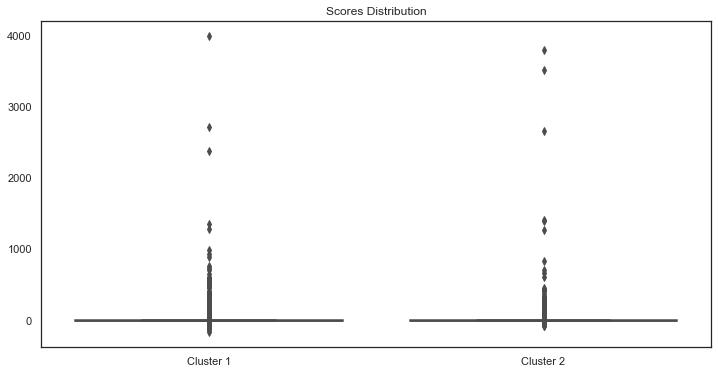

In [80]:
## plot the distribution of the scores in a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=[cluster1_scores, cluster2_scores])
plt.title('Scores Distribution')
plt.xticks([0, 1], ['Cluster 1', 'Cluster 2'])
plt.show()

Since the p-value (0.00136) is less than the alpha level (0.05), we reject the null hypothesis. This means there is statistically significant evidence to suggest a difference in the mean scores between the two groups 'discouraging_women' and 'women_lack_interest'.  